The following cell takes our super covid dataset from stage I and filters out dates not in the range of June 01, 2020 to January 3, 2021. It also filters out US states so that I only have the 6 US states that I want. In my case, I'm analyzing Arizona, Colorado, Illinois, New York, North Dakota, and Texas.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

super_covid19_data = pd.read_csv('super_covid19_data.csv')

#Filter for cases between June 01, 2020 and January 3 2021
start_date = '2020-06-01'
end_date =  '2021-01-04' 


# Filter for columns between the start_date and end_date for cases and deaths
all_columns = super_covid19_data.columns
filtered_columns = all_columns[(all_columns >= start_date) & (all_columns <= end_date)]

# Create a filtered DataFrame with only the relevant date columns
filtered_super_covid19_data = super_covid19_data[['countyFIPS', 'State', 'County Name_x', 'population'] + list(filtered_columns)]

#US state abbreviations: NY, TX, IL, AZ, CO, ND
states_to_keep = ['NY', 'TX', 'IL', 'AZ', 'CO', 'ND']

# Filter the DataFrame to keep only the rows for these states
filtered_super_covid19_data = filtered_super_covid19_data[filtered_super_covid19_data['State'].isin(states_to_keep)]

# Save the filtered dataset to a CSV file
filtered_super_covid19_data.to_csv('filtered_super_dates_June2020_Jan2021_and_6_states.csv', index=False)



This cell will aggregate the covid cases into weekly values for my 6 chosen states. <br>
(i.e. Arizona, Colorado, Illinois, New York, North Dakota, and Texas.) I also convert the cumulative data
into non-cumulative data to get a better picture of peak weeks. The numbers of the first week remain cumulative.

In [17]:
# Filter case columns
case_columns = [col for col in filtered_super_covid19_data.columns if '_cases' in col]

# Transpose the case columns to resample by week
case_data = filtered_super_covid19_data[case_columns].T

# Convert column names (remove the suffix and convert to datetime)
case_data.index = pd.to_datetime([col[:10] for col in case_columns])

# Resample by week (summing cases for each week)
weekly_cases = case_data.resample('W-SUN').sum()

# Calculate the weekly differences to get non-cumulative data
weekly_non_cumulative_cases = weekly_cases.diff().fillna(weekly_cases.iloc[0])

# Transpose back and rename the columns to indicate weeks
weekly_non_cumulative_cases = weekly_non_cumulative_cases.T
weekly_non_cumulative_cases.columns = [str(col.date()) + '_cases' for col in weekly_non_cumulative_cases.columns]

# Combine with non-date columns that contain state and county info
weekly_non_cumulative_cases_super_covid19_data = pd.concat(
    [filtered_super_covid19_data[['countyFIPS', 'State', 'County Name_x', 'population']], 
     weekly_non_cumulative_cases], 
    axis=1)

# Remove rows that do not have info on the number of cases
weekly_non_cumulative_cases_super_covid19_data = weekly_non_cumulative_cases_super_covid19_data[
    weekly_non_cumulative_cases_super_covid19_data['countyFIPS'] != 0]


This cell will aggregate the covid deaths into weekly deaths for my 6 chosen states. <br>
(i.e. Arizona, Colorado, Illinois, New York, North Dakota, and Texas.) As before, the cumulative data is converted to non-cumulative form to get a better picture of peaks in weeks. The numbers for the first week remain cumulative.

In [22]:
# Filter the death columns
death_columns = [col for col in filtered_super_covid19_data.columns if '_deaths' in col]

# Transpose the death columns to resample by week
death_data = filtered_super_covid19_data[death_columns].T

# Convert column names (remove the suffix and convert to datetime)
death_data.index = pd.to_datetime([col[:10] for col in death_columns])

# Resample by week (summing deaths for each week)
weekly_deaths = death_data.resample('W-SUN').sum()

# Calculate non-cumulative weekly deaths by taking the difference between consecutive weeks
non_cumulative_weekly_deaths = weekly_deaths.diff().fillna(weekly_deaths)

# Transpose back and rename the columns to indicate weeks
non_cumulative_weekly_deaths = non_cumulative_weekly_deaths.T
non_cumulative_weekly_deaths.columns = [str(col.date()) + '_deaths' for col in non_cumulative_weekly_deaths.columns]

# Combine with non-date columns that contain state and county info
non_cumulative_weekly_deaths_super_covid19_data = pd.concat([filtered_super_covid19_data[['countyFIPS', 'State', 'County Name_x', 'population']], non_cumulative_weekly_deaths], axis=1)

# Remove rows that do not have info on the number of deaths
non_cumulative_weekly_deaths_super_covid19_data = non_cumulative_weekly_deaths_super_covid19_data[non_cumulative_weekly_deaths_super_covid19_data['countyFIPS'] != 0]


<h3>Weekly Statistics for New York</h3>

The following cell will show the mean, median, and mode for the number of cases and deaths across the state of New York. It also shows a line plot of the number of cases and deaths per 100,000 people.

New York weekly cases statistics: 

Mean weekly cases: 1702.0830303030302
Median weekly cases: 117.5
Mode weekly cases:  0    0.0
Name: 0, dtype: float64


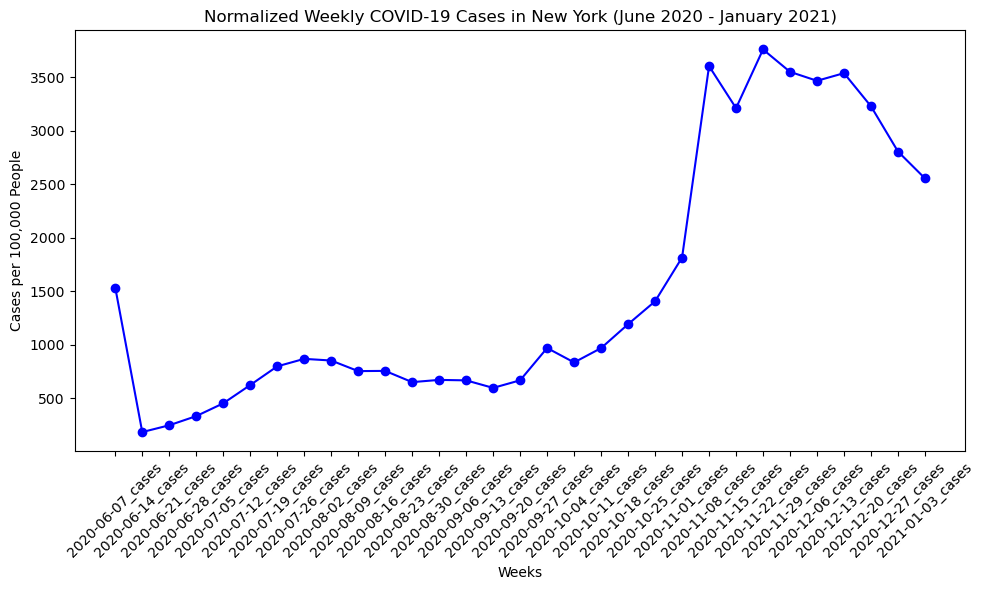



New York weekly deaths statistics: 

Mean weekly deaths: 26.094484848484846
Median weekly deaths: 0.0
Mode weekly deaths:  0    0.0
Name: 0, dtype: float64


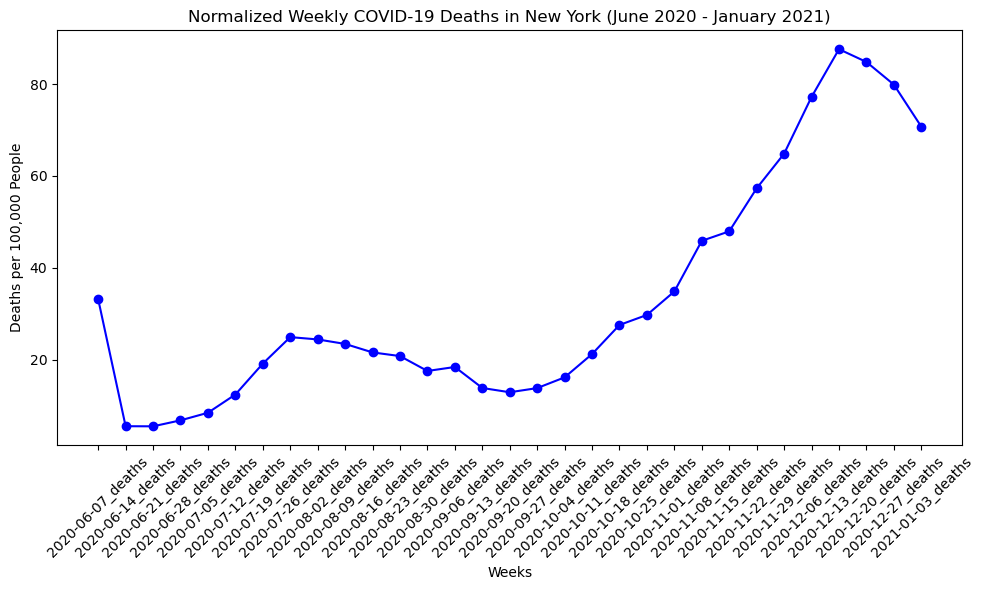

In [23]:
# Remove rows that don't contain 'NY' in the State column
ny_weekly_cases = weekly_non_cumulative_cases_super_covid19_data
[weekly_non_cumulative_cases_super_covid19_data['State'].str.contains('NY') == True]

# Identify the columns for weekly cases
ny_weekly_case_columns = [col for col in ny_weekly_cases.columns if '_cases' in col]

# Calculate the average weekly cases for each county excluding the first week
county_avg_weekly_cases = ny_weekly_cases[ny_weekly_case_columns[1:]].mean(axis=1)

# Replace the first week's values with the calculated average for each county
ny_weekly_cases.loc[:, ny_weekly_case_columns[0]] = county_avg_weekly_cases

# Save a copy to use later for the 5 counties of my choice
ny_weekly_cases.to_csv('NY_weekly_cases.csv', index=False)

# The mean, median, and mode across all weeks
overall_mean = ny_weekly_cases[ny_weekly_case_columns].mean().mean()  
overall_median = ny_weekly_cases[ny_weekly_case_columns].median().median()  
ny_weekly_case_modes = ny_weekly_cases[ny_weekly_case_columns].mode().iloc[0]  # First mode value of all weeks

overall_mode = ny_weekly_case_modes.mode()

# Print the mean, median, and mode
print("New York weekly cases statistics: \n")
print("Mean weekly cases:", overall_mean)
print("Median weekly cases:", overall_median)
print("Mode weekly cases: ", overall_mode)

# Normalize each week's cases by the population per 100,000 individuals for each county
normalized_ny_weekly_cases = ny_weekly_cases[ny_weekly_case_columns].div(ny_weekly_cases['population'], axis=0) * 100000

# Sum normalized cases for each week across all counties
ny_weekly_cases_normalized_sum = normalized_ny_weekly_cases.mean()

# Plot the normalized weekly cases
plt.figure(figsize=(10, 6))
plt.plot(ny_weekly_case_columns, ny_weekly_cases_normalized_sum, marker='o', linestyle='-', color='b')
plt.title('Normalized Weekly COVID-19 Cases in New York (June 2020 - January 2021)')
plt.xlabel('Weeks')
plt.ylabel('Cases per 100,000 People')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print('\n') #Weekly death stats below this

# Remove rows that don't contain 'NY' in the State column
ny_weekly_deaths = non_cumulative_weekly_deaths_super_covid19_data
[non_cumulative_weekly_deaths_super_covid19_data['State'].str.contains('NY') == True]

# Identify the columns for weekly deaths
ny_weekly_death_columns = [col for col in ny_weekly_deaths.columns if '_deaths' in col]

# Calculate the average weekly cases for each county excluding the first week
county_avg_weekly_deaths = ny_weekly_deaths[ny_weekly_death_columns[1:]].mean(axis=1)

# Replace the first week's values with the calculated average for each county
ny_weekly_deaths[ny_weekly_death_columns[0]] = county_avg_weekly_deaths

# Save a copy to use later for the 5 counties of my choice
ny_weekly_deaths.to_csv('NY_weekly_deaths.csv', index=False)

# The mean, median, and mode across all weeks for deaths
overall_mean_deaths = ny_weekly_deaths[ny_weekly_death_columns].mean().mean()  
overall_median_deaths = ny_weekly_deaths[ny_weekly_death_columns].median().median()  
weekly_death_modes = ny_weekly_deaths[ny_weekly_death_columns].mode().iloc[0]  # First mode value of all weeks

overall_mode_deaths = weekly_death_modes.mode()

# Print the mean, median, and mode for weekly deaths
print("New York weekly deaths statistics: \n")
print("Mean weekly deaths:", overall_mean_deaths)
print("Median weekly deaths:", overall_median_deaths)
print("Mode weekly deaths: ", overall_mode_deaths)

# Normalize each week's deaths by the population per 100,000 individuals for each county
normalized_ny_weekly_deaths = ny_weekly_deaths[ny_weekly_death_columns].div(ny_weekly_deaths['population'], axis=0) * 100000

# Sum normalized deaths for each week across all counties
ny_weekly_deaths_normalized_sum = normalized_ny_weekly_deaths.mean()

# Plot the normalized weekly deaths
plt.figure(figsize=(10, 6))
plt.plot(ny_weekly_death_columns, ny_weekly_deaths_normalized_sum, marker='o', linestyle='-', color='b')
plt.title('Normalized Weekly COVID-19 Deaths in New York (June 2020 - January 2021)')
plt.xlabel('Weeks')
plt.ylabel('Deaths per 100,000 People')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The next cell makes a line plot for the cases and deaths the states of Arizona, Colorado, Illinois, North Dakota, and Texas.

AZ weekly cases statistics:
Mean weekly cases: 7793.608888888888
Median weekly cases: 1068.0
Mode weekly cases: 0.0

AZ weekly deaths statistics:
Mean weekly deaths: 122.07777777777775
Median weekly deaths: 33.0
Mode weekly deaths: 0.0

--------------------------------------------------

CO weekly cases statistics:
Mean weekly cases: 1117.8489583333333
Median weekly cases: 35.5
Mode weekly cases: 0.0

CO weekly deaths statistics:
Mean weekly deaths: 12.033333333333333
Median weekly deaths: 0.0
Mode weekly deaths: 0.0

--------------------------------------------------

IL weekly cases statistics:
Mean weekly cases: 1915.6228758169932
Median weekly cases: 256.0
Mode weekly cases: 0.0

IL weekly deaths statistics:
Mean weekly deaths: 28.013398692810455
Median weekly deaths: 2.0
Mode weekly deaths: 0.0

--------------------------------------------------

ND weekly cases statistics:
Mean weekly cases: 394.10880503144654
Median weekly cases: 61.0
Mode weekly cases: 0.0

ND weekly deaths sta

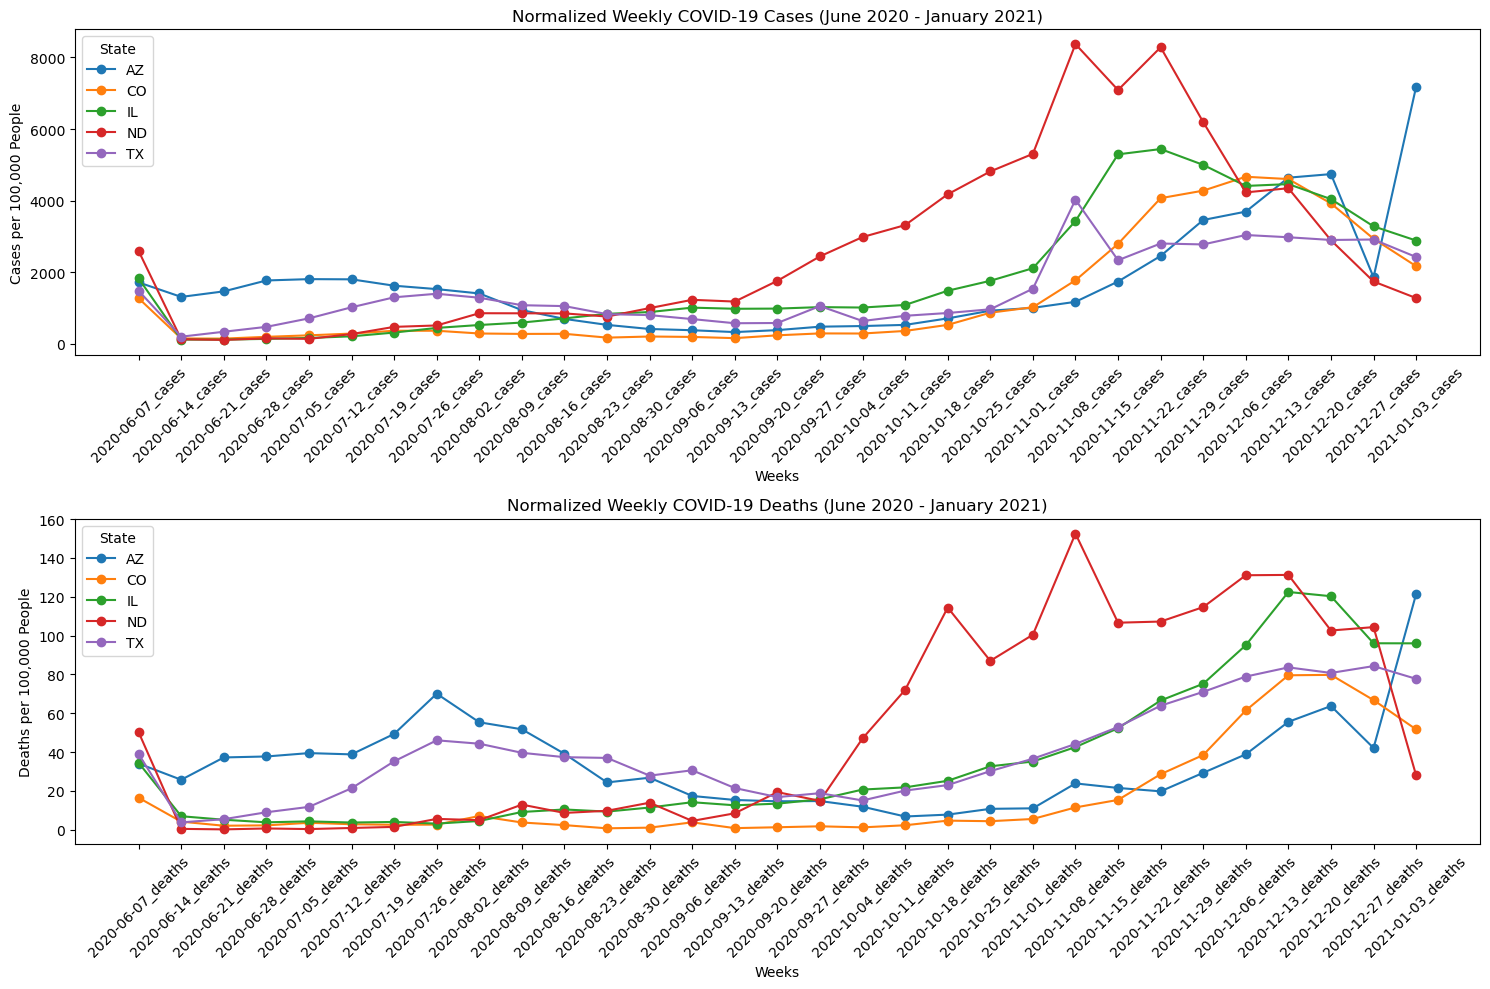

In [25]:
# The other 5 states to plot on a graph
states = ['AZ', 'CO', 'IL', 'ND', 'TX']

# Create figure for combined plots
plt.figure(figsize=(15, 10))

# Iterate through each state and calculate weekly statistics
for state in states:
    # Filter for the specific state
    state_weekly_cases = weekly_non_cumulative_cases_super_covid19_data[
        weekly_non_cumulative_cases_super_covid19_data['State'].str.contains(state) == True
    ]
    state_weekly_deaths = non_cumulative_weekly_deaths_super_covid19_data[
        non_cumulative_weekly_deaths_super_covid19_data['State'].str.contains(state) == True
    ]

    # Identify the columns for weekly cases and deaths
    weekly_case_columns = [col for col in state_weekly_cases.columns if '_cases' in col]
    weekly_death_columns = [col for col in state_weekly_deaths.columns if '_deaths' in col]

    # Calculate the average weekly cases and deaths for each county excluding the first week
    county_avg_weekly_cases = state_weekly_cases[weekly_case_columns[1:]].mean(axis=1)
    county_avg_weekly_deaths = state_weekly_deaths[weekly_death_columns[1:]].mean(axis=1)

    # Replace the first week's values with the calculated average for each county
    state_weekly_cases.loc[:, weekly_case_columns[0]] = county_avg_weekly_cases
    state_weekly_deaths.loc[:, weekly_death_columns[0]] = county_avg_weekly_deaths

    # Calculate mean, median, and mode for weekly cases
    overall_mean_cases = state_weekly_cases[weekly_case_columns].mean().mean()  
    overall_median_cases = state_weekly_cases[weekly_case_columns].median().median()  
    state_weekly_case_modes = state_weekly_cases[weekly_case_columns].mode().iloc[0]  # First mode value of all weeks
    overall_mode_cases = state_weekly_case_modes.mode()[0]  # Mode of the mode values

    # Calculate mean, median, and mode for weekly deaths
    overall_mean_deaths = state_weekly_deaths[weekly_death_columns].mean().mean()  
    overall_median_deaths = state_weekly_deaths[weekly_death_columns].median().median()  
    state_weekly_death_modes = state_weekly_deaths[weekly_death_columns].mode().iloc[0]  # First mode value of all weeks
    overall_mode_deaths = state_weekly_death_modes.mode()[0]  # Mode of the mode values

    # Print statistics for the current state
    print(f"{state} weekly cases statistics:")
    print("Mean weekly cases:", overall_mean_cases)
    print("Median weekly cases:", overall_median_cases)
    print("Mode weekly cases:", overall_mode_cases)
    print()

    print(f"{state} weekly deaths statistics:")
    print("Mean weekly deaths:", overall_mean_deaths)
    print("Median weekly deaths:", overall_median_deaths)
    print("Mode weekly deaths:", overall_mode_deaths)
    print('\n' + '-'*50 + '\n')

    # Normalize weekly cases and deaths by population per 100,000 individuals
    normalized_weekly_cases = state_weekly_cases[weekly_case_columns].div(state_weekly_cases['population'], axis=0) * 100000
    normalized_weekly_deaths = state_weekly_deaths[weekly_death_columns].div(state_weekly_deaths['population'], axis=0) * 100000

    # Sum normalized cases and deaths for each week across all counties
    weekly_cases_normalized_sum = normalized_weekly_cases.mean()
    weekly_deaths_normalized_sum = normalized_weekly_deaths.mean()

    # Plot normalized weekly cases for the state
    plt.subplot(2, 1, 1)
    plt.plot(weekly_case_columns, weekly_cases_normalized_sum, marker='o', linestyle='-', label=state)
    plt.title('Normalized Weekly COVID-19 Cases (June 2020 - January 2021)')
    plt.xlabel('Weeks')
    plt.ylabel('Cases per 100,000 People')
    plt.xticks(rotation=45)
    plt.legend(title='State')

    # Plot normalized weekly deaths for the state
    plt.subplot(2, 1, 2)
    plt.plot(weekly_death_columns, weekly_deaths_normalized_sum, marker='o', linestyle='-', label=state)
    plt.title('Normalized Weekly COVID-19 Deaths (June 2020 - January 2021)')
    plt.xlabel('Weeks')
    plt.ylabel('Deaths per 100,000 People')
    plt.xticks(rotation=45)
    plt.legend(title='State')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()



The rates differ across the states because...